In [40]:
from sola.main_classes.mappings import FiniteLinearMapping, IntegralMapping, DirectSumMapping
from sola.main_classes.spaces import PCb, RN, DirectSumSpace
from sola.main_classes.functions import *
import seaborn as sns
import random

# Create color Palette
colors = sns.color_palette('YlGnBu', n_colors=100)

In seismology we often have to deal with model-data relationships such as:
$
\begin{equation}
 d_i = \int_{\Omega} K^{\rho}_i \delta \rho + \int_{\Omega} K^{v_s}_i\delta v_s + \int_{\Omega} K^{v_p}_i\delta v_p + K^{\Sigma}_i\delta \Sigma
\end{equation}
$

where a model is formed by the tuple $m = (\delta \rho, \delta v_s, \delta v_p, \delta \Sigma)$ (density perturbation, shear wave speed perturbation, compressional wave speed perturbation, CMB perturbation). Each component in the tuple is called (by us) a physical parameter, and in the case of $\delta \rho, \delta v_s, \delta v_p$ these are functions defined on the spatial domain $\Omega$, and $\delta \Sigma$ is a real number. The various sensitivity kernels are denoted with $K$ and they are of the same kind as their correpsonding physical parameter. More importantly, each integral/multiplication is just an inner product defined on some appropriate Hilbert space. Therefore, we can generalize the relation to:

$
\begin{equation}
d_i = \left< K_i, m \right>_{\mathcal{M}} = \sum_j \left< K^j_i, m^j \right>_{\mathcal{M}_j}
\end{equation}
$

where each physical parameter $m^j$ and its corresponding sensitivity kernels $K^j_i$ are members of some space $\mathcal{M}_j$ on which we have defined an inner product $\left< \cdot, \cdot \right>_{\mathcal{M}_j}$. Grouping together the physical parameters into the tuple $m$, and the set of sensitivity kernels into the tuples K_i we obtain members of the space $\mathcal{M}$ which is formed from the direct sum of all the spaces $\mathcal{M}_j$. Such a composite space can be dealt with using the "DirectSumSpace" class.

In [41]:
####################
# Create model space
####################
# Edit region -------------
# We create some names for the physical parameters
physical_parameters = ['vs', 'vp', 'rho', 'sigma']
# And give them some symbols for plotting
physical_parameters_symbols = {'vs': '$\delta v_s$', 'vp': '$\delta v_p$', 'rho': '$\delta \\rho$', 'sigma': '$\delta \\Sigma$'}
# Edit region -------------

no_of_params = len(physical_parameters)
# Create a domain for the functions
Domain = HyperParalelipiped(bounds=[[0, 1]], fineness=1000)
# Create spaces for the first three physical parameters which are functions
constituent_models_spaces = [PCb(domain=Domain) for _ in physical_parameters[0:3]]
# and a space for the last one which is a real number
constituent_models_spaces += [RN(dimension=1)]
# Create a dictionary with physical_parameters as keys
models_dict = {param: model_space for param, model_space in zip(physical_parameters, constituent_models_spaces)}
M = DirectSumSpace(tuple(constituent_models_spaces))

In [42]:
###################
# Create Data space
###################
# Edit region -------------
how_many_data = 150
# Edit region -------------

D = RN(dimension=how_many_data)

Just as we can form a direct sum space we can also create a an appropriate mapping from the the model $\mathcal{M}$ into the data space using smaller mappings defined on the individual spaces $\mathcal{M}_j$. 

First we create some fake sensitivity kernels:

In [43]:
###########################
# Create model-data mapping
###########################
# Make a dictionary with the physical parameters as keys and the sensitivities as values
sensitivity_dict = {}
for i, param in enumerate(physical_parameters):
    sensitivity_dict[param] = []
    for index in range(how_many_data):
        if i in [0, 1, 2]:
            # The first three paramters are functions
            sensitivity_dict[param].append(NormalModes_1D(domain=Domain, order=3, spread=0.05,
                                                        max_freq=10, seed=index + i*how_many_data))
        else:
            # The last parameter is a real number
            sensitivity_dict[param].append(random.uniform(0, 1))
# Collect all the mappings in a list
constituent_mappings = [IntegralMapping(domain=models_dict[param], codomain=D,
                                        kernels=sensitivity_dict[param]) for param in physical_parameters[0:3]]
constituent_mappings += [FiniteLinearMapping(domain=constituent_models_spaces[-1],
                                             codomain=D, matrix=np.array(sensitivity_dict['sigma']).reshape(D.dimension, 1))]
mappings_dict = {param: mapping for param, mapping in zip(physical_parameters, constituent_mappings)}
# and feed them into the DirectSumMapping object to combine them into a single mapping from M to D
G = DirectSumMapping(domain=M, codomain=D, mappings=tuple(constituent_mappings))

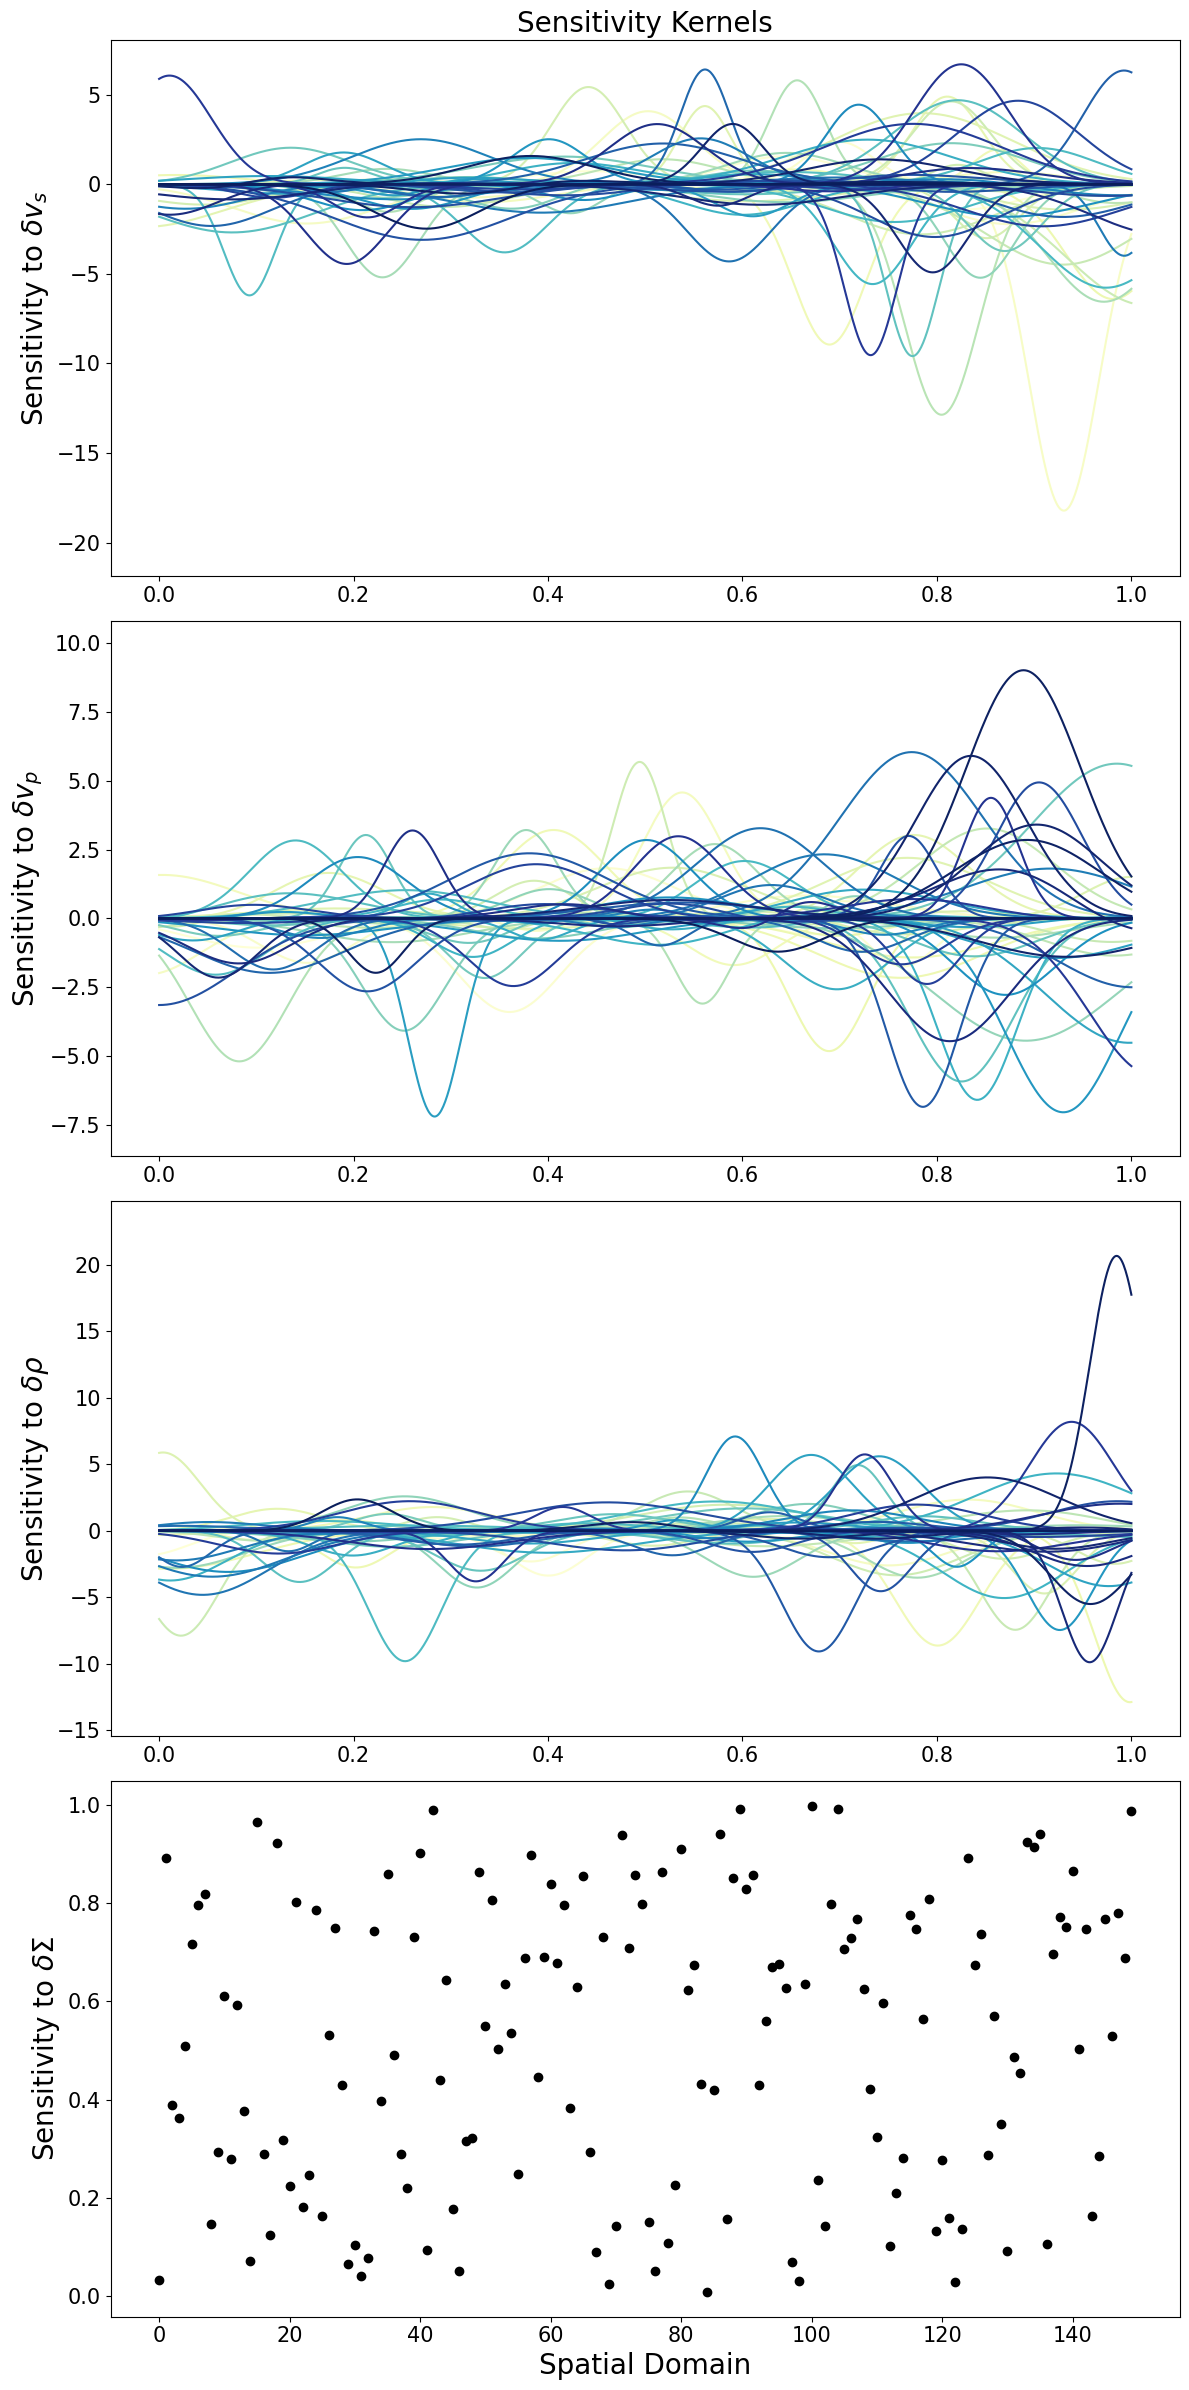

In [44]:
%matplotlib inline
# Now we plot the sensitivity kernels
fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12, 6*len(physical_parameters)))

for i, param in enumerate(physical_parameters):
    # Initialize y_min and y_max with extreme values to be updated dynamically
    y_min = float('inf')
    y_max = float('-inf')

    if i in [0, 1, 2]:
        for j, kernel in enumerate(sensitivity_dict[param]):
            y_values = kernel.evaluate(Domain.mesh)  # Extract y-values from the kernel data

            # Update y_min and y_max based on current kernel's data
            y_min = min(y_min, np.min(y_values))
            y_max = max(y_max, np.max(y_values))

            axes[i].plot(Domain.mesh, y_values, color=colors[int(100*j/how_many_data)])
        y_min *= 1.2
        y_max *= 1.2
        axes[i].tick_params(axis='both', which='major', labelsize=15)
        axes[i].set_ylim([y_min, y_max])
        axes[i].set_ylabel('Sensitivity to ' + physical_parameters_symbols[param], fontsize=20)
    else:
        axes[i].scatter(range(how_many_data), sensitivity_dict[param], color='black')
        axes[i].set_ylabel('Sensitivity to ' + physical_parameters_symbols[param], fontsize=20)

# Adjust fontsize for ticks
axes[0].set_title('Sensitivity Kernels', fontsize=20)
axes[i].set_xlabel('Spatial Domain', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('Kernels_for_paper.pdf', bbox_inches='tight', dpi=300)
plt.show()

With the model and data spaces created, and the mapping between them formed, we can start mapping members.

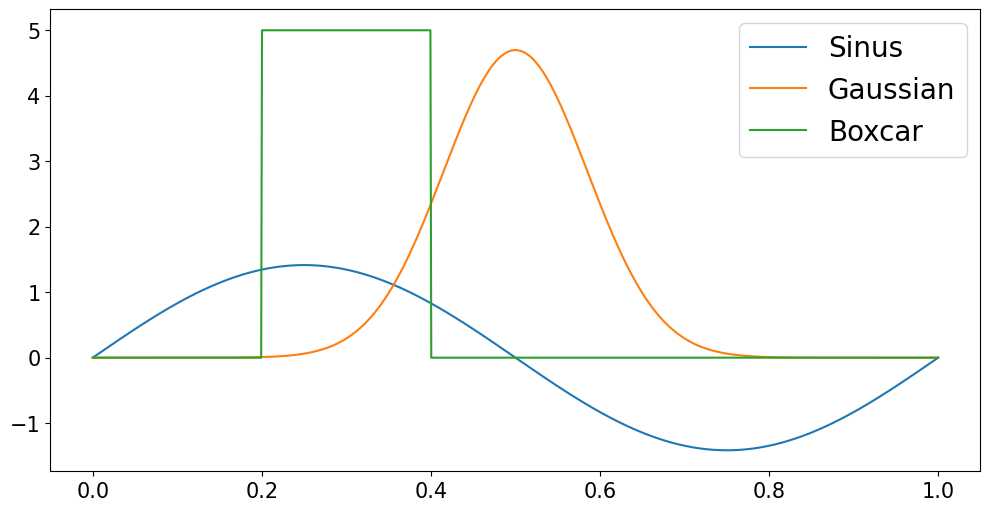

In [45]:
# First we create functions for the first three physical parameters (completely finctional, of course)
gaussian = Gaussian_1D(domain=Domain, center=0.5, width=0.5)
Sinus = Fourier(domain=Domain, type='sin', order=1)
Boxcar = Boxcar_1D(domain=Domain, center=0.3, width=0.2)

plt.figure(figsize=(12, 6))
plt.plot(Domain.mesh, Sinus.evaluate(Domain.mesh), label='Sinus')
plt.plot(Domain.mesh, gaussian.evaluate(Domain.mesh), label='Gaussian')
plt.plot(Domain.mesh, Boxcar.evaluate(Domain.mesh), label='Boxcar')
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# Now we create a scalar for the last physical parameter
constant = 1

# And we combine them into a tuple, which is a member of the model space M
m = tuple([Sinus, gaussian, Boxcar, constant])

In [46]:
print(G.map(m))

[[ 0.27660307]
 [ 0.88183969]
 [-0.68432891]
 [ 0.42625714]
 [-0.15493053]
 [ 0.87957638]
 [ 1.13757426]
 [ 0.50157643]
 [ 0.80048328]
 [ 0.28020702]
 [ 0.18404733]
 [ 1.9762919 ]
 [ 0.17614417]
 [ 0.3504495 ]
 [-0.55301098]
 [ 2.10256709]
 [ 2.45208493]
 [-0.64543946]
 [ 1.0379658 ]
 [ 0.09242761]
 [ 0.20674764]
 [ 0.9265735 ]
 [-0.3741751 ]
 [-0.00731603]
 [ 0.64292729]
 [-0.81535804]
 [ 0.50384639]
 [ 2.09203713]
 [ 0.58552093]
 [ 0.41727202]
 [ 0.66645901]
 [ 0.41684773]
 [-0.0160161 ]
 [ 0.17653826]
 [ 2.7836277 ]
 [ 1.15094433]
 [ 1.03842239]
 [ 0.06014104]
 [ 0.29437654]
 [ 0.71676507]
 [ 0.86269089]
 [ 1.7658246 ]
 [ 0.49151194]
 [-0.53380724]
 [ 1.07967295]
 [ 0.26825522]
 [ 0.33964808]
 [ 0.03335007]
 [ 0.86534155]
 [ 0.92724842]
 [ 0.43385552]
 [-0.67218287]
 [ 2.23403206]
 [ 0.46176125]
 [ 0.30857038]
 [ 0.06454828]
 [ 0.0660283 ]
 [ 1.39374994]
 [ 0.65997223]
 [-0.28614511]
 [ 1.19052991]
 [ 0.87378962]
 [ 0.91731211]
 [-1.16303798]
 [ 0.72510796]
 [ 1.73681694]
 [-0.06447

We can also compute the adjoint of this direct sum mapping:

In [47]:
G_adj = G.adjoint

And we can map members of the data space back to the model space.

Sigma [[0.03346044]]


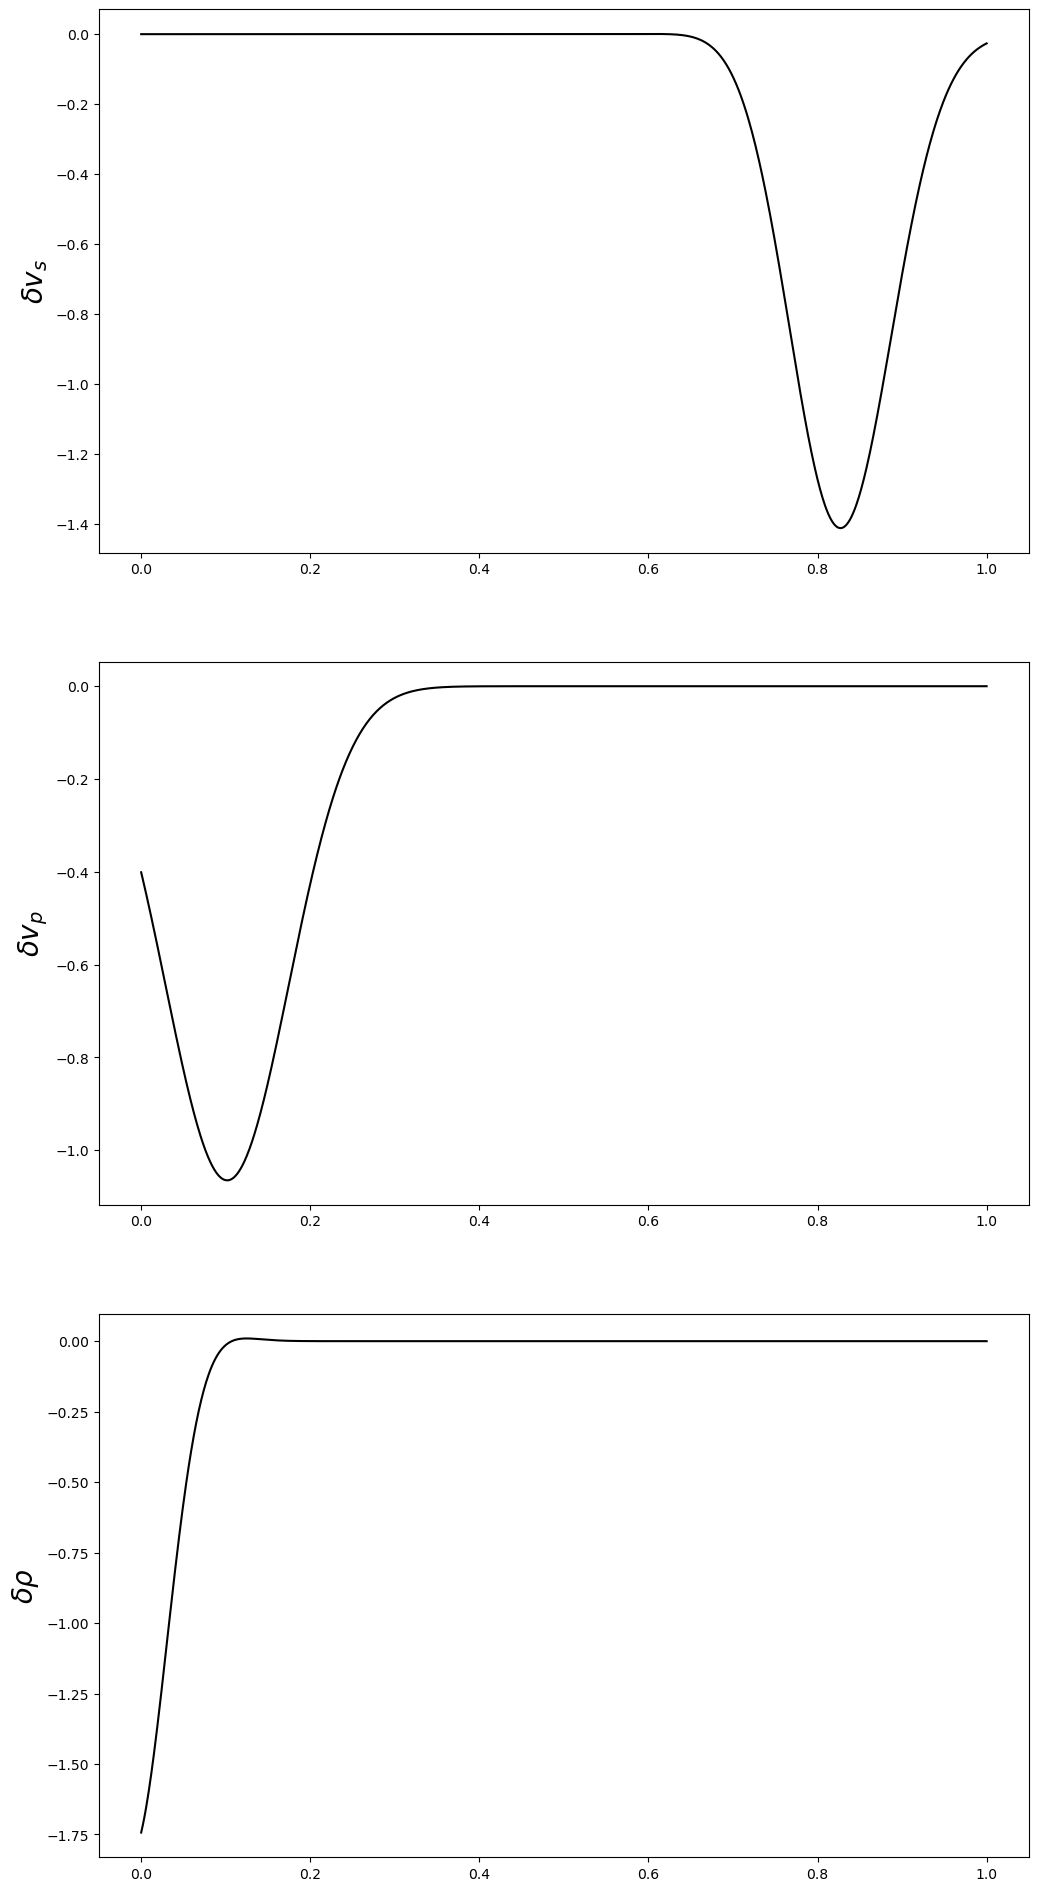

In [48]:
member_D = np.zeros(D.dimension).reshape(D.dimension, 1)
member_D[0, 0] = 1

member_M = G_adj.map(member_D)

fig, axes = plt.subplots(len(physical_parameters) - 1,
                         1, figsize=(12, 6*len(physical_parameters)))

for i, param in enumerate(physical_parameters):
    if i in [0, 1, 2]:
        axes[i].plot(Domain.mesh, member_M[i].evaluate(Domain.mesh), color='black')
        axes[i].set_ylabel(physical_parameters_symbols[param], fontsize=20)
print('Sigma', member_M[-1])